### Sensor Constants

In [3]:
sensor_name = 'alpha_no2_conc'

## Upload Data from File

In [4]:
import pandas as pd

directory_path = 'input/'
file_name = sensor_name + '_and_temp_valid.csv'
df = pd.read_csv(directory_path + file_name)
df.head()

,DateTime,measuring,Hour,temperature,raw measuring
0,2022-11-27 17:00:00,95.788822,17,29.265,191.577644
1,2022-11-27 17:30:00,142.977153,17,30.005,174.436041
2,2022-11-27 17:45:00,166.441306,17,30.085,181.106401
3,2022-11-27 18:00:00,180.351261,18,30.120,188.962186
4,2022-11-27 18:15:00,185.672619,18,30.135,188.962186


### Create Sensor Dataframe as Pandas Series

In [5]:
# Remove the first column with the indexes and save data into web dataframe
dataframe = df.drop(df.columns[0], axis='columns')
dataframe['DateTime'] = (pd.to_datetime(df['DateTime'], infer_datetime_format=True))

# Resample data with 15 mins period and create sensor dataframe
sensor_dataframe = dataframe.sort_values(by='DateTime', ascending=True).reset_index().drop(columns='index')
sensor_dataframe.index = sensor_dataframe['DateTime']
sensor_dataframe = sensor_dataframe.drop(columns=['DateTime'])
sensor_dataframe = sensor_dataframe[['measuring', 'raw measuring', 'temperature', 'Hour']]
sensor_dataframe.head()

/var/folders/wc/_83zcrx913j1dqwg4g90kbhh0000gp/T/ipykernel_10686/1926727337.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dataframe['DateTime'] = (pd.to_datetime(df['DateTime'], infer_datetime_format=True))


,measuring,raw measuring,temperature,Hour
DateTime,,,,
2022-11-27 17:00:00,95.788822,191.577644,29.265,17
2022-11-27 17:30:00,142.977153,174.436041,30.005,17
2022-11-27 17:45:00,166.441306,181.106401,30.085,17
2022-11-27 18:00:00,180.351261,188.962186,30.120,18
2022-11-27 18:15:00,185.672619,188.962186,30.135,18


### Plot raw data

<Axes: xlabel='DateTime'>

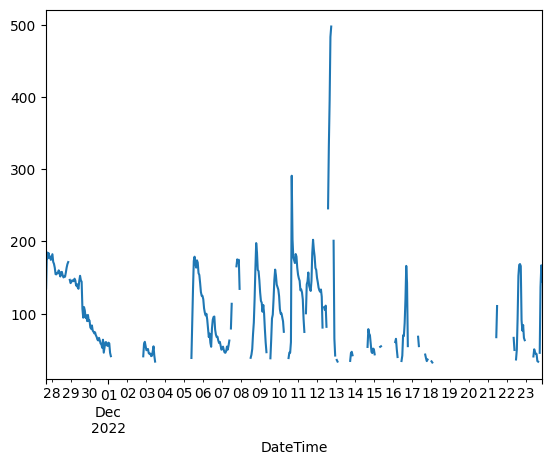

In [6]:
sensor_dataframe['measuring'].resample('1H').mean().plot()

## Compare with original data

In [7]:
input_data_directory = 'input/'
reference_data_path = input_data_directory + 'ref_air_quality_data_Vila_Moema.csv'
reference_column_name = 'Dióxido de Nitrogênio'

## Load reference and sensor data

In [8]:
import pandas as pd

reference_data = pd.read_csv(reference_data_path)
reference_data['DateTime'] = (pd.to_datetime(reference_data['DateTime'], infer_datetime_format=True))
reference_data = reference_data.sort_values(by='DateTime', ascending=True).reset_index().drop(columns='index')
reference_data.index = reference_data['DateTime']
reference_data = reference_data.drop(columns='DateTime')[reference_column_name]

sensor_data = sensor_dataframe
reference_data.head()

/var/folders/wc/_83zcrx913j1dqwg4g90kbhh0000gp/T/ipykernel_10686/1347629147.py:4: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  reference_data['DateTime'] = (pd.to_datetime(reference_data['DateTime'], infer_datetime_format=True))


DateTime
2022-01-01 02:30:00    4.02
2022-01-01 03:30:00    4.38
2022-01-01 04:30:00    8.66
2022-01-01 05:30:00    8.57
2022-01-01 06:30:00    8.10
Name: Dióxido de Nitrogênio, dtype: float64

## Merge sensor and reference data

In [9]:
merged_data = pd.concat([sensor_data, reference_data], axis=1, join='inner')
sensor_data = merged_data.rename(columns={'Dióxido de Nitrogênio': 'reference'})
sensor_data.head()

,measuring,raw measuring,temperature,Hour,reference
DateTime,,,,,
2022-11-27 17:30:00,142.977153,174.436041,30.005,17,3.15
2022-11-27 18:30:00,187.705656,188.962186,30.135,18,4.18
2022-11-27 19:30:00,173.473138,172.300397,30.085,19,5.51
2022-11-27 20:30:00,185.306770,185.866913,30.035,20,5.29
2022-11-27 21:30:00,176.957597,176.816297,29.960,21,5.02


### Plot reference and sensor data

<Axes: xlabel='DateTime'>

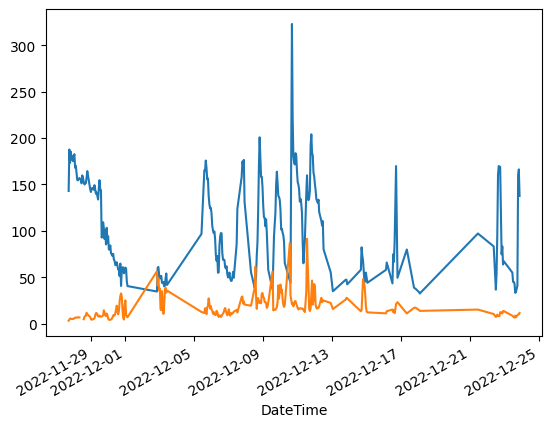

In [10]:
sensor_data['measuring'].plot()
sensor_data['reference'].plot()

<Axes: >

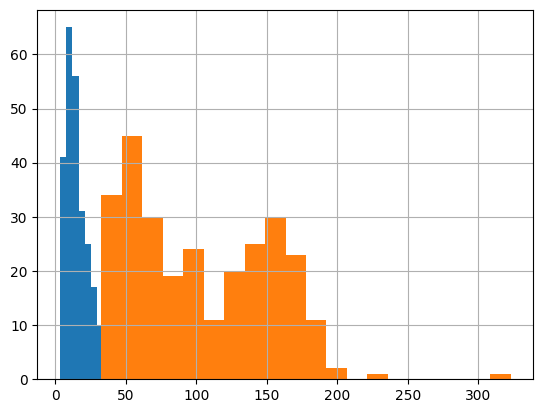

In [11]:
sensor_data['reference'].hist(bins=20)
sensor_data['measuring'].hist(bins=20)

## Plot sensor vs. reference

Spearmans correlation coefficient: -0.073
Samples are uncorrelated (fail to reject H0) p=0.229
Kendall correlation coefficient: -0.073
Samples are uncorrelated (fail to reject H0) p=0.229


Text(0.05, 0.9, "Kendall's tau=-0.044, p<0.05")

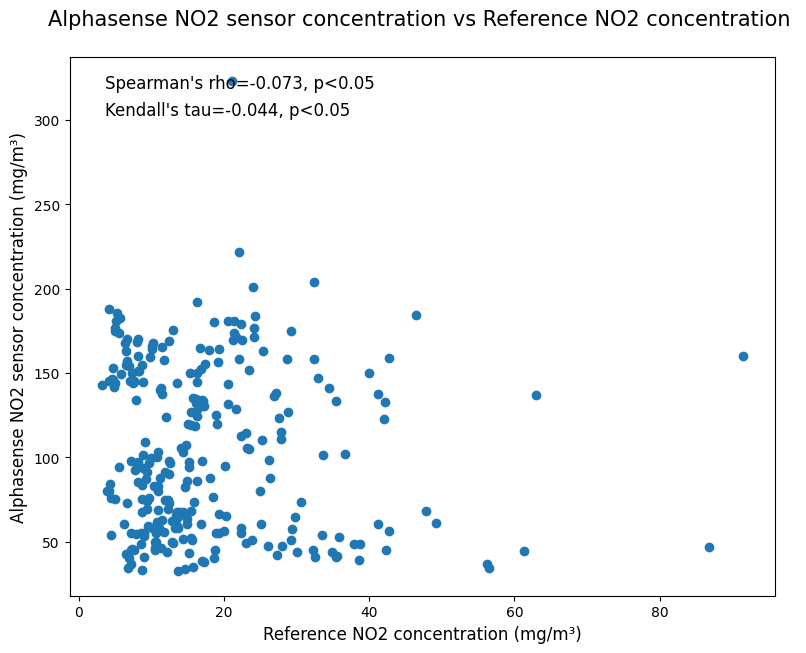

In [12]:
from scipy.stats import spearmanr
from scipy.stats import kendalltau
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(1.3*7,7))

plt.scatter(sensor_data['reference'], sensor_data['measuring'])
plt.title('Alphasense NO2 sensor concentration vs Reference NO2 concentration \n', 
          fontdict={'fontsize':15})
plt.xlabel('Reference NO2 concentration (mg/m\N{SUPERSCRIPT THREE})', 
           fontsize=12)
plt.ylabel('Alphasense NO2 sensor concentration (mg/m\N{SUPERSCRIPT THREE})', 
           fontsize=12)
coef, p = spearmanr(sensor_data['reference'], sensor_data['measuring'], 
                    nan_policy='omit')
print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
	print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
	print('Samples are correlated (reject H0) p=%.3f' % p)

kendall, pken = kendalltau(sensor_data['reference'], sensor_data['measuring'], 
                            nan_policy='omit')
print('Kendall correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
	print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
	print('Samples are correlated (reject H0) p=%.3f' % p)
 
string = 'Spearman\'s rho=%.3f, p<0.05' % coef
plt.text(0.05, 0.95, string, horizontalalignment='left', fontsize=12,
         verticalalignment='center', transform=ax.transAxes)
string = 'Kendall\'s tau=%.3f, p<0.05' % kendall
plt.text(0.05, 0.90, string, horizontalalignment='left', fontsize=12,
         verticalalignment='center', transform=ax.transAxes)

## Calibrate data

### Prepare training and test sets

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

reference_median = sensor_data['reference'].median()
sensor_median = sensor_data['measuring'].median()
temperature_mean = sensor_data['temperature'].mean()

y = sensor_data['reference'].fillna(value=reference_median).values.reshape(-1,1)
X = (sensor_data[['measuring','temperature']].fillna(value={'measuring': sensor_median,
                                                        'temperature': temperature_mean}).values.reshape(-1,2))

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Grid search with different models and variables combinations

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import  MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import numpy as np

# Define different subsets of input variables
feature_subsets = {
    'NO2': [0],
    'NO2 and temperature': [0, 1]
}
    
models = {
    'MLP Regression': (
        ('mlp_regressor', MLPRegressor(solver="lbfgs", max_iter=1000, random_state=42)), {
            'mlp_regressor__hidden_layer_sizes': [
                (4,),   (10,),   (50,),   (100,),  (200,),
                (4,4),  (4,10),  (4,50),  (4,100), (4,200),
                (10,4), (10,10), (10,50), (10,100),(10,200),
                (50,4), (50,10), (50,50), (50,100),(50,200), 
                (100,4),(100,10),(100,50),(100,100),(100,200),
                (200,4),(200,10),(200,50),(200,100),(200,200)],
            'mlp_regressor__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]
        }
    ),
    'Multilinear Regression': (
        ('linear_regressor', LinearRegression()), { }
    ),
    'KNN Regression': (
        ('knn_regressor', KNeighborsRegressor()), {
            'knn_regressor__n_neighbors': [3, 5, 7], #[3, 5, 7, 9, 11, 13, 15, 17, 20],
            'knn_regressor__weights': ['uniform', 'distance'],
            'knn_regressor__p': [1, 2]  # 1 for Manhattan distance, 2 for Euclidean distance'
        }
    ),
    'Random Forests Regression': (
        ('random_forest_regressor', RandomForestRegressor()), {
            'random_forest_regressor__n_estimators': [50, 100, 150],
            'random_forest_regressor__max_depth': [None, 10, 20, 30],
            'random_forest_regressor__min_samples_split': [2, 5, 10],
            'random_forest_regressor__min_samples_leaf': [1, 2, 4]
        }
    )
}

# Perform grid search for each feature subset
results = {}
rmse_by_features = {}
r2_by_features = {}
mae_by_features = {}
for features_set, subset in feature_subsets.items():
    X_subset = X[:, subset]
    X_train_subset = X_train[:, subset]
    X_test_subset = X_test[:, subset]

    model_results = {}
    model_rmse = {}
    model_r2 = {}
    model_mae = {}
    for model_name, (model, param_grid) in models.items():
        print(f"Grid search for features: {features_set} with model: {model_name}...")
        
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            model
        ])
        
        # Perform grid search with cross-validation
        grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='r2', n_jobs=-1)
        grid_search.fit(X_train_subset, y_train)

        # Print the best parameters and best score
        best_params = grid_search.best_params_

        # Evaluate the best model on the test set
        best_model = grid_search.best_estimator_
        cross_validation = cross_validate(best_model, X_subset, y, cv=10, scoring=['r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_error'])
        y_pred = best_model.predict(X_test_subset)

        # Evaluate the model
        r2 = cross_validation['test_r2']
        rmse = cross_validation['test_neg_root_mean_squared_error']
        mae = cross_validation['test_neg_mean_absolute_error']

        model_results[model_name] = {
            'Best Model': best_model,
            'Best Parameters': best_params,
            'Test R2': r2,
            'Test RMSE': rmse,
            'Test MAE': mae
        }
        model_rmse[model_name] = {
            'Mean': rmse.mean(),
            'Std': rmse.std()
        }
        model_r2[model_name] = {
            'Mean': r2.mean(),
            'Std': r2.std()
        }
        model_mae[model_name] = {
            'Mean': mae.mean(),
            'Std': mae.std()
        }

    results[features_set] = model_results
    rmse_by_features[features_set] = model_rmse
    r2_by_features[features_set] = model_r2
    mae_by_features[features_set] = model_mae

for feature_set, models in results.items():
    for model_name, result in models.items():
        print(f"\nResults for features: {feature_set} with model: {model_name}:")
        print(f"Best Parameters: {result['Best Parameters']}")
        print(f"Test RMSE: {result['Test RMSE'].mean()} +/- {result['Test RMSE'].std()}")
        print(f"Test R2: {result['Test R2'].mean()} +/- {result['Test R2'].std()}")
        print(f"Test MAE: {result['Test MAE'].mean()} +/- {result['Test MAE'].std()}")

Grid search for features: NO2 with model: MLP Regression...


/Users/Fernando/Documents/Projects/Github/lcqar-low-cost-monit-proc/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Fernando/Documents/Projects/Github/lcqar-low-cost-monit-proc/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Fernando/Documents/Projects/Github/lcqar-low-cost-monit-proc/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel()

Grid search for features: NO2 with model: Multilinear Regression...
Grid search for features: NO2 with model: KNN Regression...
Grid search for features: NO2 with model: Random Forests Regression...


/Users/Fernando/Documents/Projects/Github/lcqar-low-cost-monit-proc/venv/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/Fernando/Documents/Projects/Github/lcqar-low-cost-monit-proc/venv/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/Fernando/Documents/Projects/Github/lcqar-low-cost-monit-proc/venv/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/Fernando/Docume

Grid search for features: NO2 and temperature with model: MLP Regression...


/Users/Fernando/Documents/Projects/Github/lcqar-low-cost-monit-proc/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Fernando/Documents/Projects/Github/lcqar-low-cost-monit-proc/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Fernando/Documents/Projects/Github/lcqar-low-cost-monit-proc/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel()

Grid search for features: NO2 and temperature with model: Multilinear Regression...
Grid search for features: NO2 and temperature with model: KNN Regression...
Grid search for features: NO2 and temperature with model: Random Forests Regression...


/Users/Fernando/Documents/Projects/Github/lcqar-low-cost-monit-proc/venv/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/Fernando/Documents/Projects/Github/lcqar-low-cost-monit-proc/venv/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/Fernando/Documents/Projects/Github/lcqar-low-cost-monit-proc/venv/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/Fernando/Docume


Results for features: NO2 with model: MLP Regression:
Best Parameters: {'mlp_regressor__alpha': 0.1, 'mlp_regressor__hidden_layer_sizes': (10, 100)}
Test RMSE: -14.14051400236696 +/- 4.6231797283191085
Test R2: -6.1691763486322975 +/- 8.935088365574613
Test MAE: -10.666623840389889 +/- 2.6733417655250595

Results for features: NO2 with model: Multilinear Regression:
Best Parameters: {}
Test RMSE: -12.851270727982339 +/- 3.916569141458112
Test R2: -4.248828618847919 +/- 6.190632656391682
Test MAE: -9.908849479747328 +/- 1.8779987823512905

Results for features: NO2 with model: KNN Regression:
Best Parameters: {'knn_regressor__n_neighbors': 7, 'knn_regressor__p': 1, 'knn_regressor__weights': 'uniform'}
Test RMSE: -13.578033713906024 +/- 3.480448543005803
Test R2: -5.379677610965023 +/- 7.837946463302704
Test MAE: -10.236530990173849 +/- 2.173567603689137

Results for features: NO2 with model: Random Forests Regression:
Best Parameters: {'random_forest_regressor__max_depth': 30, 'random_

/Users/Fernando/Documents/Projects/Github/lcqar-low-cost-monit-proc/venv/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


# Save Results

In [15]:
output_directory_path = 'output/'
rmse_file_name = output_directory_path + sensor_name + '_rmse.csv'
r2_file_name = output_directory_path + sensor_name + '_r2.csv'
mae_file_name = output_directory_path + sensor_name + '_mae.csv'
results_file_name = output_directory_path + sensor_name + '_results.csv'

pd.DataFrame(rmse_by_features).transpose().to_csv(rmse_file_name)
pd.DataFrame(r2_by_features).transpose().to_csv(r2_file_name)
pd.DataFrame(mae_by_features).transpose().to_csv(mae_file_name)
pd.DataFrame(results).transpose().to_csv(results_file_name)